This notebook is intended to analyze the effect of different instruments on classification performance

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from collections import OrderedDict
import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
import glob, re
import seaborn as sns
pd.set_option('display.max_rows', 500) 
pd.set_option('display.max_columns', 100)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.utils.multiclass import type_of_target # used to check the Y labels are appropriate for classification
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.utils import shuffle
from scipy import interp

from scipy.stats import mannwhitneyu

In [2]:
def scatterplot(xs, ys, ss, cs, ls, sscale=1, sbins=None):
    ax = plt.gca()
    cm = plt.get_cmap('rainbow')
    for i, c in enumerate(cs.unique()):
        ax.scatter(xs[cs==c],
                    ys[cs==c],
                    s=ss*sscale if isinstance(ss,int) else ss[cs==c]*sscale,
                    c=cm(1.*i/len(cs.unique())),
                    edgecolor='k',
                    alpha=0.9,
                    vmin=0, vmax=len(cs.unique()),
                   label='_nolegend_')
        ax.scatter([],[],c=cm(1.*i/len(cs.unique())),edgecolor='k',label=c)
    ax.scatter([],[],marker='None',label=' ')
    if not isinstance(ss,int):
        for s in sbins:
            ax.scatter([],[],c='k',edgecolor='k',s=s*sscale,label=str(s))
            ax.scatter([],[],marker='None',label=' ')
    for x, y, l in zip(xs, ys, ls):
        ax.text(x, y, l, color='k', ha='center', va='center')
    ax.set_xlabel(xs.name)
    ax.set_ylabel(ys.name)
    ax.legend()
    ax.grid()

In [3]:
datasets = OrderedDict()
for fn in sorted(glob.glob('./bn_pickles/*.pkl')):
    data = pd.read_pickle(open(fn,'rb'))
    datasets[data[0]['study']] = data

auc_summary = pd.read_pickle('./auc_sigfeat_df_YES_bn_NO_log_NO_standscal_NO_multi_mapped_labels.pkl')
auc_summary = auc_summary.set_index('analysis')
auc_sum_order = list(auc_summary.index)
auc_summary

,auc,auc_std,case,control,disease,disease_type,features,label,model_nonzero_coef,number_labels,samples,significant,study,test_size,train_size
analysis,,,,,,,,,,,,,,,
plasmaall_author,0.996667,0.004714,59,43,coronary heart disease,cardiovascular,109,a0,19,2,102,108,Feng,33,69
urineall_author,0.990351,0.008877,59,43,coronary heart disease,cardiovascular,160,a1,160,2,102,160,Feng,33,69
serum_IPO_aligned_Feng_serum_batch1,1.000000,0.000000,21,20,coronary heart disease,cardiovascular,5529,a2,222,2,41,1587,Feng,13,28
serum_IPO_aligned_Feng_serum_batch2,1.000000,0.000000,38,23,coronary heart disease,cardiovascular,4939,a3,51,2,61,1110,Feng,19,42
urine_IPO_aligned_Feng_urine_batch1,1.000000,0.000000,28,21,coronary heart disease,cardiovascular,11102,a4,50,2,49,1440,Feng,16,33
urine_IPO_aligned_Feng_urine_batch2,0.971429,0.040406,31,22,coronary heart disease,cardiovascular,11884,a5,69,2,53,2128,Feng,17,36
serum_onebatch_IPO_align_Feng_serum_all,0.998810,0.001684,59,43,coronary heart disease,cardiovascular,5040,a6,40,2,102,1523,Feng,33,69
urine_onebatch_IPO_aligned_Feng_urine_all,0.976190,0.033672,59,43,coronary heart disease,cardiovascular,11934,a7,257,2,102,2564,Feng,33,69
IPO_aligned_MTBLS105_qMS,0.662061,0.118154,40,49,Hepatocellular carcinoma,cancer,1176,b0,1175,2,89,0,MTBLS105,29,60


In [4]:
ms_col_mode = pd.read_csv('ms_instrument_column_polarity_dataset_names.csv').rename(columns={'study':'analysis'}).set_index('analysis')
# print(ms_col_mode)
rename = {f:f.strip() for f in ms_col_mode.index}
ms_col_mode = ms_col_mode.rename(rename)
rename_2 = {'postive':'positive'}
ms_col_mode = ms_col_mode.rename(rename_2)
# ms_col_index = list(ms_col_mode.index)
# for s in auc_sum_order:
#     print(auc_summary.loc[s][['auc']], ms_col_mode.loc[s]['Instrument_category'])
# print(len(auc_sum_order))
# print(len(ms_col_index))
ms_col_mode = ms_col_mode.loc[auc_sum_order]
auc_ms_summary = pd.concat([auc_summary,ms_col_mode], axis=1)
auc_ms_summary

,auc,auc_std,case,control,disease,disease_type,features,label,model_nonzero_coef,number_labels,samples,significant,study,test_size,train_size,Accession,Instrument_category,Instument,column,mode,type
analysis,,,,,,,,,,,,,,,,,,,,,
plasmaall_author,0.996667,0.004714,59,43,coronary heart disease,cardiovascular,109,a0,19,2,102,108,Feng,33,69,Feng,LC,LTQ orbitrap,C18,positive,plasma
urineall_author,0.990351,0.008877,59,43,coronary heart disease,cardiovascular,160,a1,160,2,102,160,Feng,33,69,Feng,LC,LTQ orbitrap,C18,positive,urine
serum_IPO_aligned_Feng_serum_batch1,1.000000,0.000000,21,20,coronary heart disease,cardiovascular,5529,a2,222,2,41,1587,Feng,13,28,Feng,LC,LTQ orbitrap,C18,positive,plasma
serum_IPO_aligned_Feng_serum_batch2,1.000000,0.000000,38,23,coronary heart disease,cardiovascular,4939,a3,51,2,61,1110,Feng,19,42,Feng,LC,LTQ orbitrap,C18,positive,plasma
urine_IPO_aligned_Feng_urine_batch1,1.000000,0.000000,28,21,coronary heart disease,cardiovascular,11102,a4,50,2,49,1440,Feng,16,33,Feng,LC,LTQ orbitrap,C18,positive,urine
urine_IPO_aligned_Feng_urine_batch2,0.971429,0.040406,31,22,coronary heart disease,cardiovascular,11884,a5,69,2,53,2128,Feng,17,36,Feng,LC,LTQ orbitrap,C18,positive,urine
serum_onebatch_IPO_align_Feng_serum_all,0.998810,0.001684,59,43,coronary heart disease,cardiovascular,5040,a6,40,2,102,1523,Feng,33,69,Feng,LC,LTQ orbitrap,C18,positive,plasma
urine_onebatch_IPO_aligned_Feng_urine_all,0.976190,0.033672,59,43,coronary heart disease,cardiovascular,11934,a7,257,2,102,2564,Feng,33,69,Feng,LC,LTQ orbitrap,C18,positive,urine
IPO_aligned_MTBLS105_qMS,0.662061,0.118154,40,49,Hepatocellular carcinoma,cancer,1176,b0,1175,2,89,0,MTBLS105,29,60,MTBLS105,GC,Agilent 5975C MSD,Phenyl Arylene,positive,plasma


different things to look at:
    1) auc v. feat with colors as [instrument category, column, mode] 
    2) features as fxn of mode / column

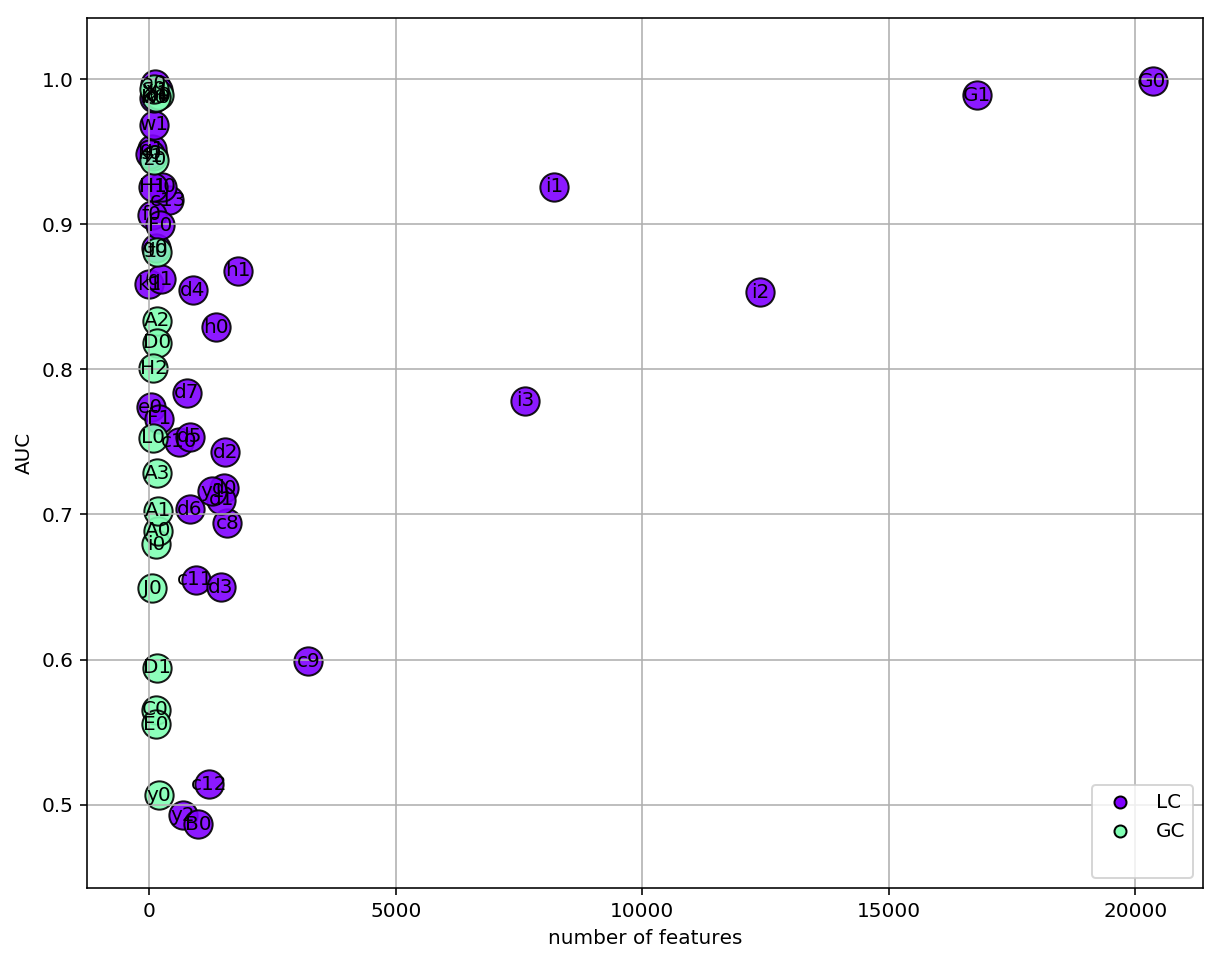

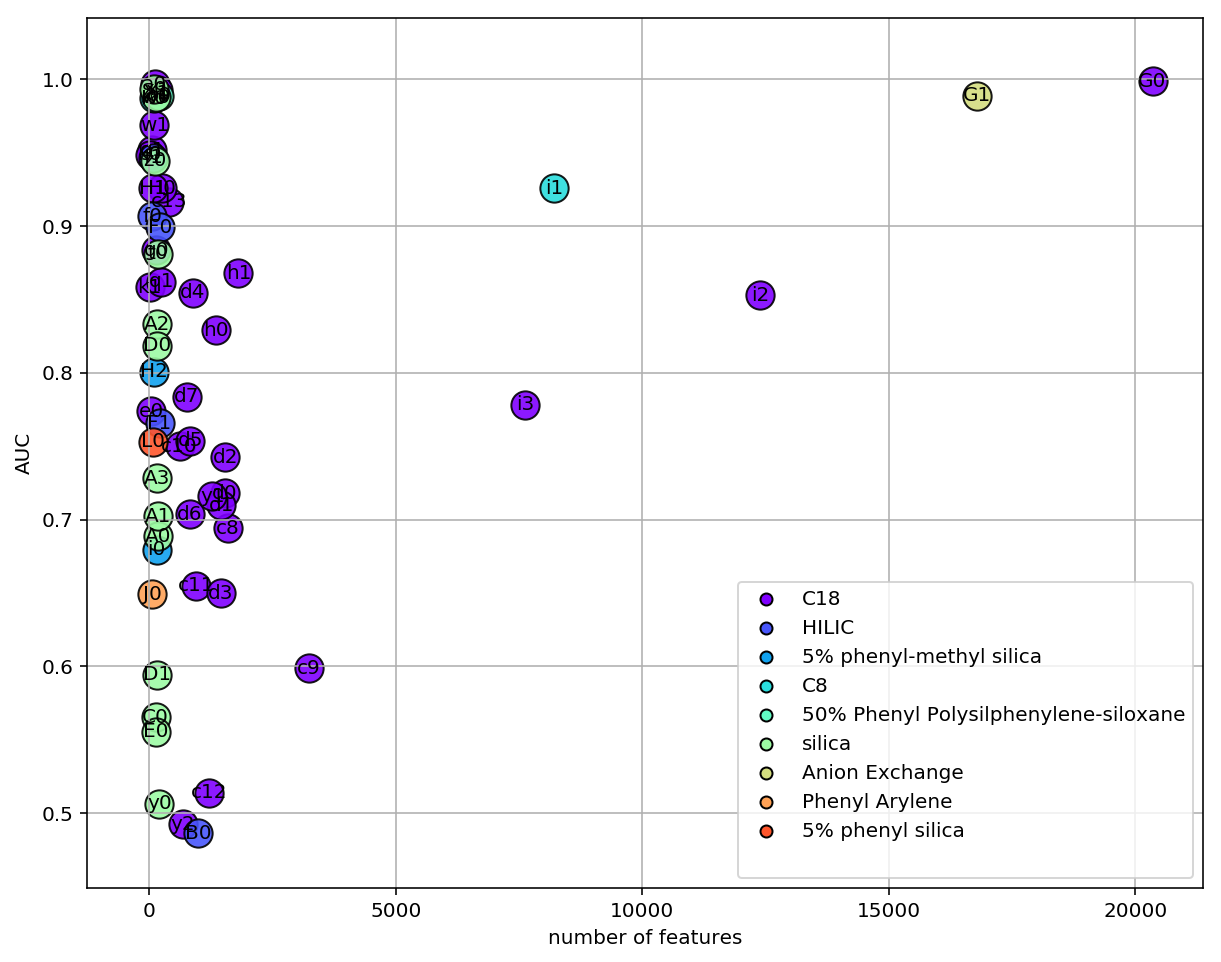

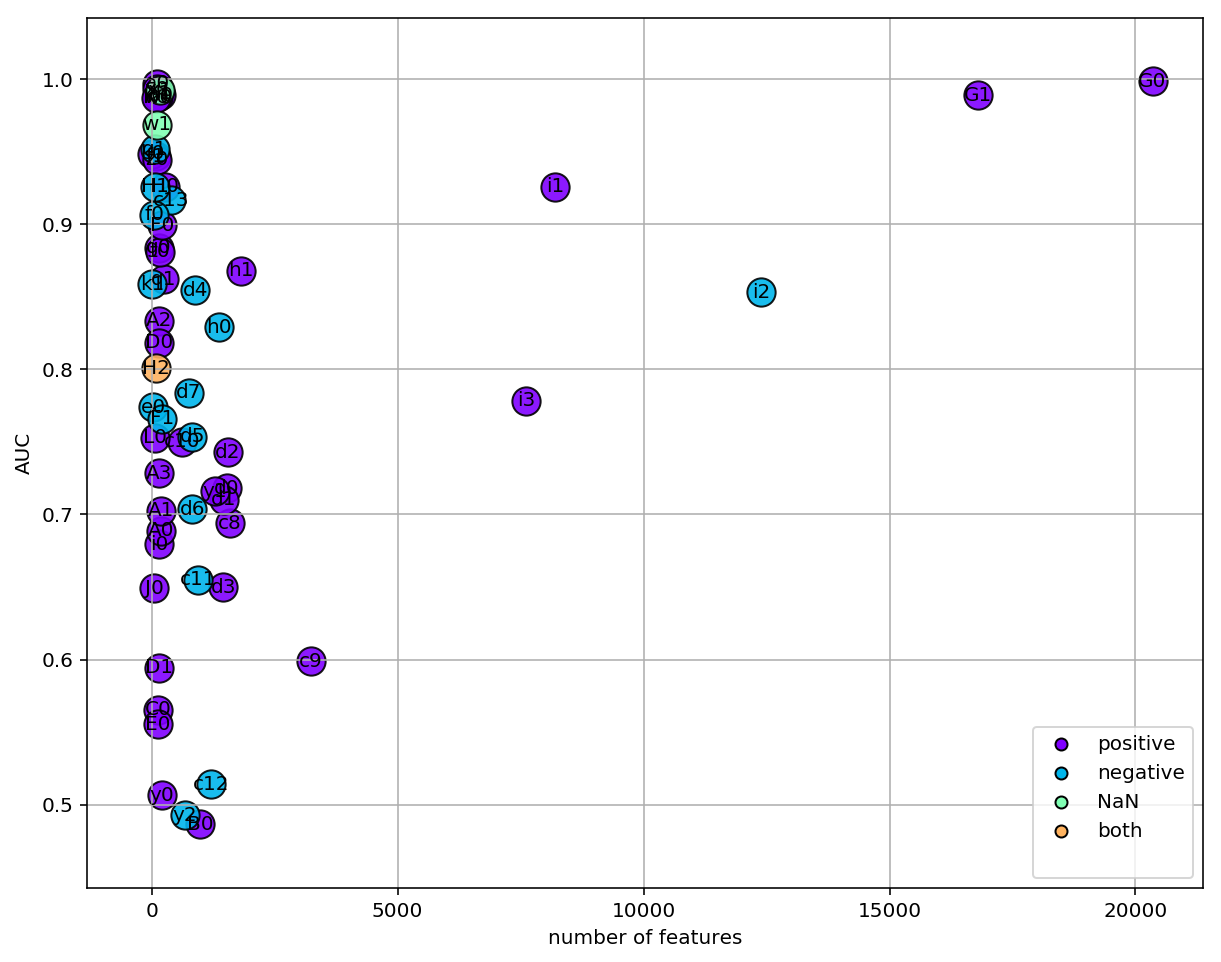

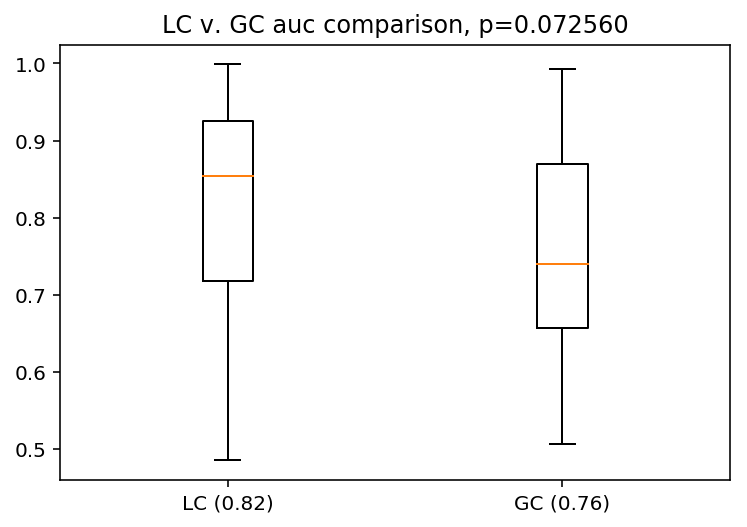

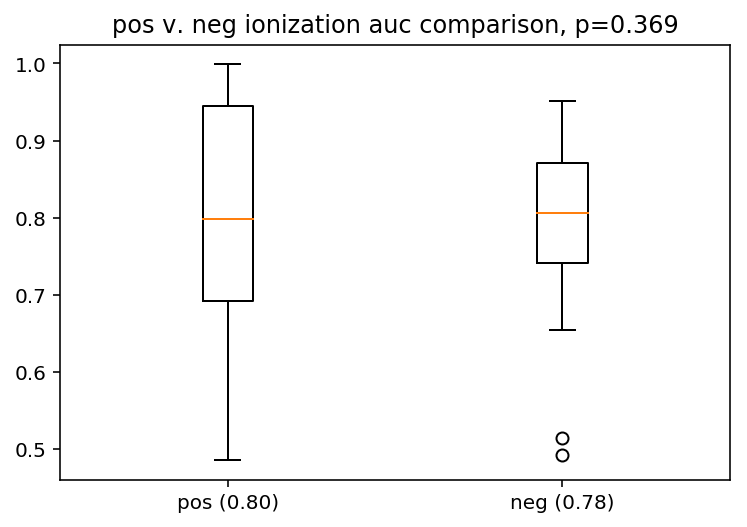

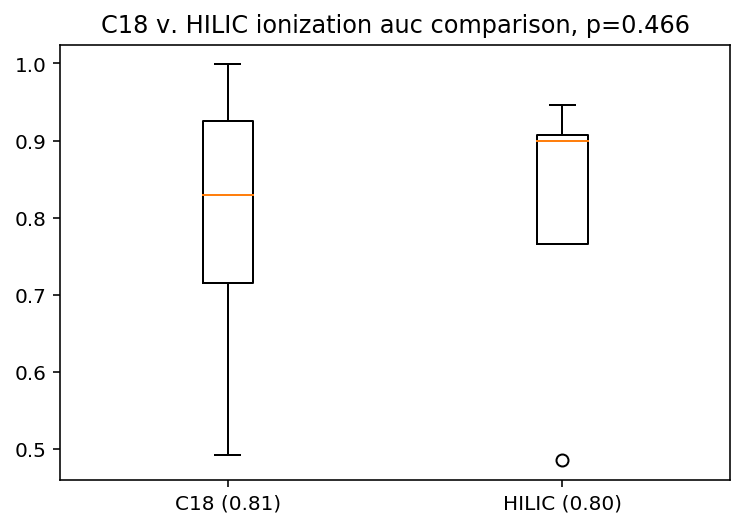

In [10]:
original_multi_class = ['ST000284', 'ST000046', 'ST000045', 'ST000763', 'ST000329', 'MTBLS358', 'MTBLS352']
no_original_multi = True
if no_original_multi:
    for multi_study in original_multi_class:
        auc_ms_summary = auc_ms_summary[auc_ms_summary['study']!=multi_study]

# Looking at all the datasets together (comment out specific rows below)
summary_w_auc = auc_ms_summary[auc_ms_summary.number_labels == 2] ###### NOTE JUST THE BINARY CLASSIFICATION PROBLEMS
indexes = list(summary_w_auc.index)
author = []
reprocessed = []
for ind in indexes:
    if 'IPO' in ind or 'XCMS' in ind:
        reprocessed.append(ind)
    else:
        author.append(ind)

###### to look at just the author data use:
summary_w_auc = summary_w_auc.loc[author]

###### to look at just the reprocessed data use:
# summary_w_auc = summary_w_auc.loc[reprocessed]

category = summary_w_auc.Instrument_category
column = summary_w_auc.column
# mode = summary_w_auc.mode
mode = summary_w_auc['mode'].replace({np.nan:'NaN'})
for var in [category, column, mode]:
    fig, ax1 = plt.subplots(1,1,figsize=(10,8))
    scatterplot(summary_w_auc.features,
                summary_w_auc.auc,
                200,
                var,
                summary_w_auc.label)
    ax1.set_xlabel('number of features')
    ax1.set_ylabel('AUC')
    plt.show()
    
#look at LC v GC studies via box plot:
lc_auc = summary_w_auc[summary_w_auc.Instrument_category=='LC']['auc']
gc_auc = summary_w_auc[summary_w_auc.Instrument_category=='GC']['auc']
_, p = mannwhitneyu(lc_auc, gc_auc)
plt.boxplot([lc_auc, gc_auc], labels=['LC (%.2f)'%lc_auc.mean(), 'GC (%.2f)'%gc_auc.mean()])
plt.title('LC v. GC auc comparison, p=%.6f'%p)
plt.show()

#look at pos v neg studies via box plot:
pos_auc = summary_w_auc[summary_w_auc['mode']=='positive']['auc']
neg_auc = summary_w_auc[summary_w_auc['mode']=='negative']['auc']
_, p = mannwhitneyu(pos_auc, neg_auc)
plt.boxplot([pos_auc, neg_auc], labels=['pos (%.2f)'%pos_auc.mean(), 'neg (%.2f)'%neg_auc.mean()])
plt.title('pos v. neg ionization auc comparison, p=%.3f'%p)
plt.show()

C18_auc = summary_w_auc[summary_w_auc['column']=='C18']['auc']
HILIC_auc = summary_w_auc[summary_w_auc['column']=='HILIC']['auc']
_, p = mannwhitneyu(C18_auc, HILIC_auc)
plt.boxplot([C18_auc, HILIC_auc], labels=['C18 (%.2f)'%C18_auc.mean(), 'HILIC (%.2f)'%HILIC_auc.mean()])
plt.title('C18 v. HILIC ionization auc comparison, p=%.3f'%p)
plt.show()

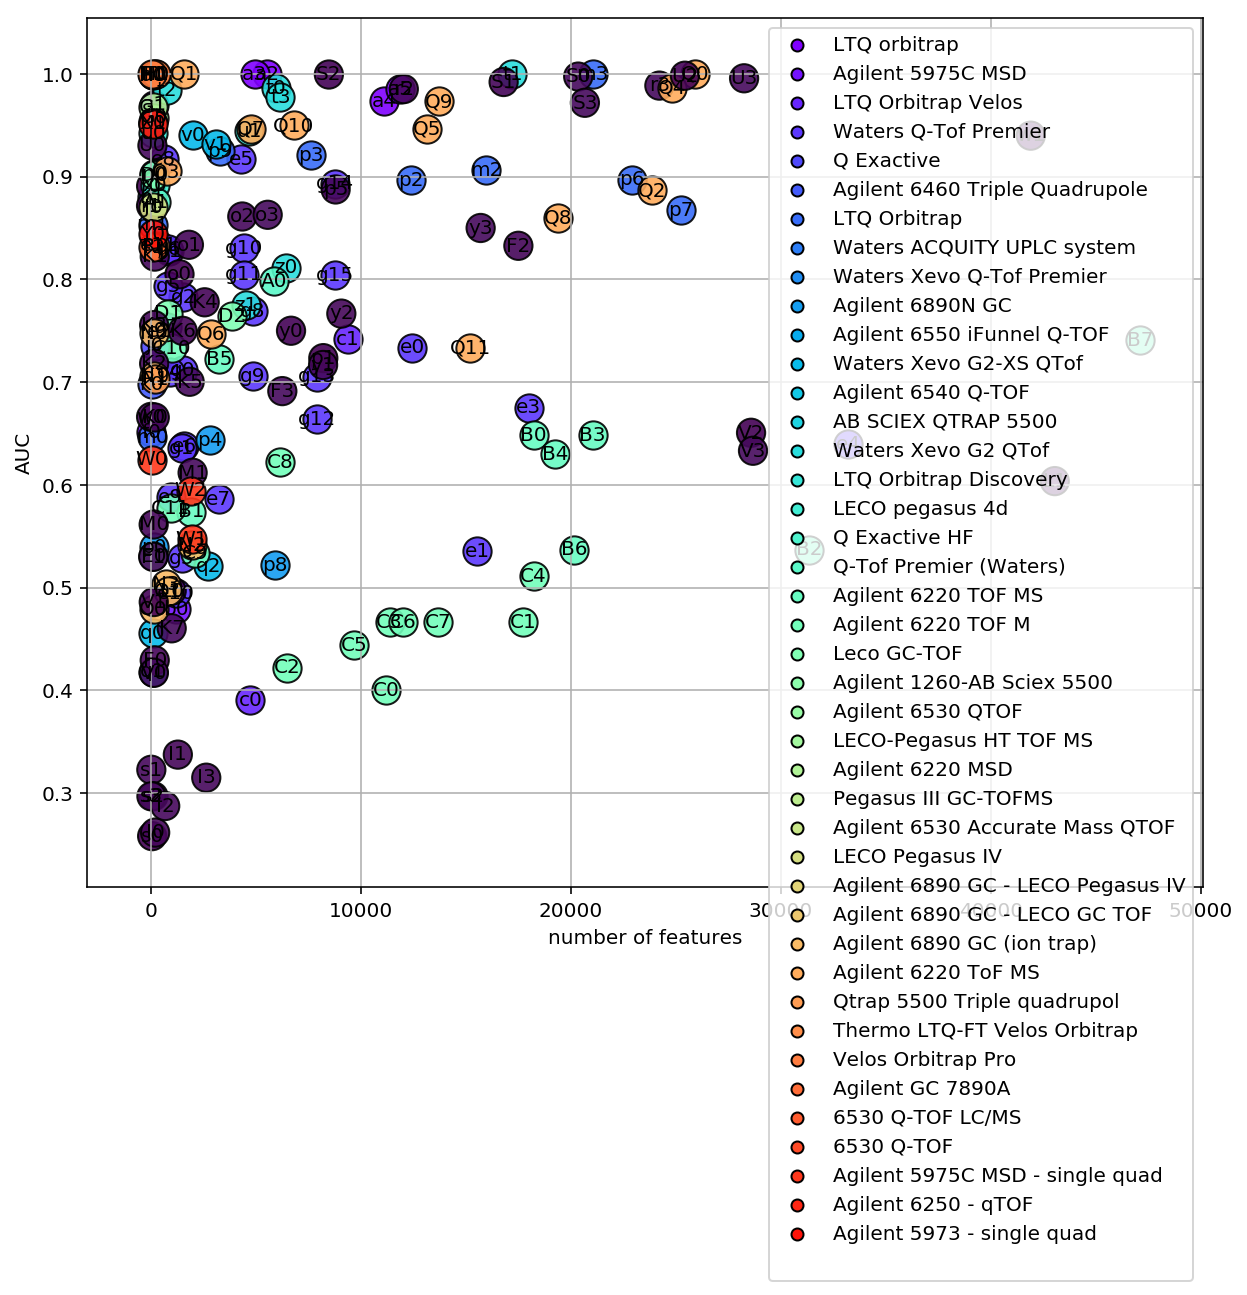

In [129]:
# Looking at all the datasets together (comment out specific rows below) for the best instrument....
summary_w_auc = auc_ms_summary[auc_ms_summary.auc != 'NA']
indexes = list(summary_w_auc.index)
author = []
reprocessed = []
for ind in indexes:
    if 'IPO' in ind or 'XCMS' in ind:
        reprocessed.append(ind)
    else:
        author.append(ind)
# to look at just the author data use:
# summary_w_auc = summary_w_auc.loc[author]
# to look at just the reprocessed data use:
# summary_w_auc = summary_w_auc.loc[reprocessed]
fig, ax1 = plt.subplots(1,1,figsize=(10,8))
scatterplot(summary_w_auc.features,
            summary_w_auc.auc,
            200,
            summary_w_auc.Instument,
            summary_w_auc.label)
ax1.set_xlabel('number of features')
ax1.set_ylabel('AUC')
plt.show()